# Notebook 2: Pre-compute echo-top variable and store back to FDB

In the previous notebooks we demonstrated how users can compute various reprojections and derived data from raw model data. However, this approach may lack efficiency when multiple users or downstream applications need to perform the same Swiss grid reprojection or interpolation to pressure levels on identical data. To optimize the process for widely beneficial and frequently reused data transformations, we aim to pre-compute and **store the results back into FDB** (write access in CSCS is only granted to the service account). 

## Configuring Access to FDB

In [1]:
import os
import logging
import sys
from pathlib import Path

from meteodatalab import mars, mch_model_data


In [2]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
cwd = Path().resolve().parent
view = cwd / "spack-env/.spack-env/view"
assert view.exists()

In [3]:
os.environ["FDB5_HOME"] = str(view)
os.environ["FDB5_CONFIG"] = """
---
type: remote
engine: remote
host: balfrin-ln003.cscs.ch
port: 30005
store: remote
"""
os.environ["FDB_REMOTE_RETRIEVE_QUEUE_LENGTH"] = "100"


## Querying Data

In [4]:
date = "20240626"
time = "1200"
request_dbz = mars.Request(
    param="DBZ",
    date=date,
    time=time,
    number=0,
    step=60,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 81)),
    model=mars.Model.ICON_CH1_EPS,
)
request_hhl = mars.Request(
    param="HHL",
    date=date,
    time=time,
    number=0,
    step=0,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)


In [5]:
ds = mch_model_data.get_from_fdb(request_dbz)
ds |= mch_model_data.get_from_fdb(request_hhl)

INFO:meteodatalab.mch_model_data:Getting request Request(param='DBZ', date='20240626', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80), number=0, step=60, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='ml', model='ICON-CH1-EPS', stream=<Stream.ENS_FORECAST: 'enfo'>, type=<Type.ENS_MEMBER: 'ememb'>, feature=None) from FDB.
INFO:meteodatalab.grib_decoder:Retrieving request: Request(param='DBZ', date='20240626', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 

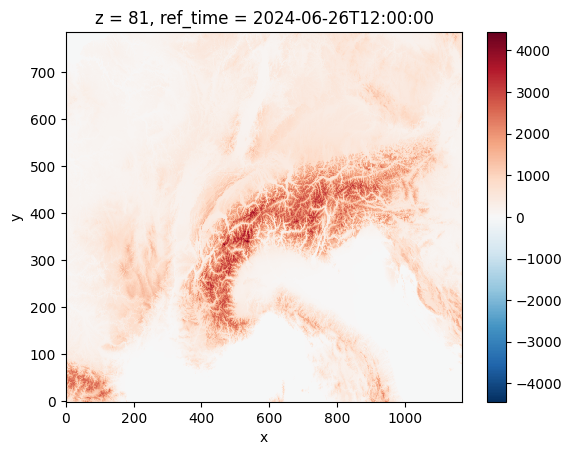

In [6]:
hhl = ds["HHL"].squeeze(drop=True)
hhl.sel(z=81).plot()


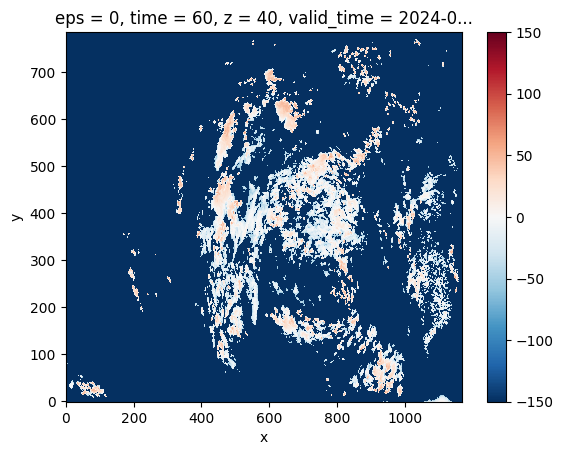

In [7]:
dbz = ds["DBZ"]
dbz.sel(z=40).plot()


## Compute "EchoTop" field

The EchoTop is related to the active core of a thundercloud and is defined as the greatest height at which a radar reflectivity of 15 dBZ is measured.

In [8]:
from meteodatalab.operators.destagger import destagger
from meteodatalab.operators.vertical_interpolation import interpolate_k2any


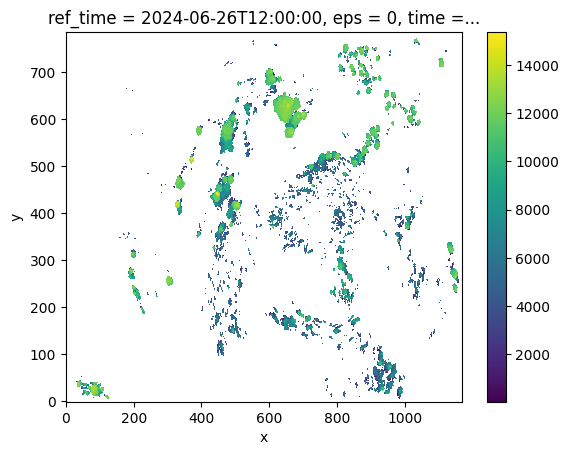

In [9]:
hfl = destagger(hhl, "z")
# interpolate height to isosurface of radar reflectivity
echo_top = interpolate_k2any(hfl, "high_fold", dbz, [15.0], hfl)
echo_top.plot()

## Write the field back to FDB

Since `interpolate_k2any` is a generic operator, the metadata has to be updated to maintain consistency with the computed values.

In [10]:
from meteodatalab import metadata


In [11]:
# override the GRIB template message metadata
echo_top.attrs |= metadata.override(
    echo_top.message, shortName="ECHOTOPinM", typeOfLevel="echoTopInDBZ"
)


In order to archive back to FDB you need write access to the FDB root directory which is only possible through the designated service account at CSCS.

In [12]:
mch_model_data.archive_to_fdb(echo_top.rename({"DBZ": "z"}))


INFO:meteodatalab.mch_model_data:Archiving field ECHOTOPinM to FDB


## Summary

- compute derived variable from direct model output
- update the metadata
- archive the result back to FDB